#### This notebook aims to compare SGD and DSCAGD on a simple task of linear regression.

In [1]:
!pip install mxnet-cu110
!pip install pytictoc
from pytictoc import TicToc
import mxnet as mx
import numpy as np
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 327.3 MB 5.6 kB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Data

We produce the data using sk-learn for linear regression

In [4]:
X,y = make_regression(n_samples=100000, n_features=1000, n_informative=100, n_targets=10, noise = 0.05, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1)
#Training data
batch_size = 2500

Transform the data for compatibility with mxnet.

In [5]:
train_iter = mx.io.NDArrayIter(X_train,y_train, batch_size, shuffle=True,label_name='lin_reg_label')
eval_iter = mx.io.NDArrayIter(X_test, y_test, batch_size, shuffle=False)

In [8]:
X = mx.sym.Variable('data')
Y = mx.symbol.Variable('lin_reg_label')
fully_connected_layer  = mx.sym.FullyConnected(data=X, name='fc1', num_hidden = 10)
lro = mx.sym.LinearRegressionOutput(data=fully_connected_layer, label=Y, name="lro")

# Optimisation of the Hyperparameters

## SGD

In [11]:
final_mse = []
for lr in np.logspace(-3,0,20):
  model = mx.mod.Module(
      symbol = lro ,
      data_names=['data'],
      label_names = ['lin_reg_label']# network structure
  )

  model.fit(train_iter, eval_iter,
              optimizer = 'sgd',
              optimizer_params={'learning_rate':lr, 'momentum': 0},
              num_epoch=10,
              eval_metric='mse')



  metric = mx.metric.MSE()
  final_mse.append(model.score(eval_iter, metric))

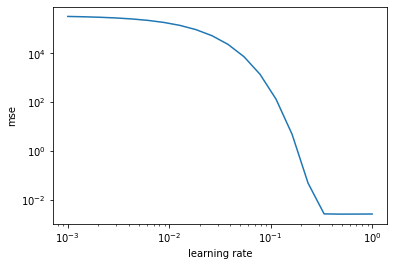

In [12]:
import matplotlib.pyplot as plt
mses = np.array(final_mse)
mses = mses[:,0,1].astype(float)
plt.plot(np.logspace(-3,0,20), mses)
plt.xlabel("learning rate")
plt.ylabel("mse")
plt.xscale('log')
plt.yscale('log')
plt.show()


## DCASGD

In [13]:
final_mse = []
metric = mx.metric.MSE()

for i,lr in enumerate(np.logspace(0,-2,10)):
  row = []
  for j,lamda in enumerate(np.logspace(-1,-5,10)):
    model = mx.mod.Module(
        symbol = lro ,
        data_names=['data'],
        label_names = ['lin_reg_label']# network structure
    )

    model.fit(train_iter, eval_iter,
                optimizer = 'dcasgd',
                optimizer_params={'learning_rate':lr, 'lamda': lamda},
                num_epoch=10,
                eval_metric='mse')

    result = np.array(model.score(eval_iter, metric))
    row.append(result[0,1])
  final_mse.append(row)

/usr/local/lib/python3.7/dist-packages/mxnet/metric.py:1198: RuntimeWarning: overflow encountered in square
  mse = ((label - pred)**2.0).mean()
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


In [14]:
final_mse = np.array(final_mse).astype(float)

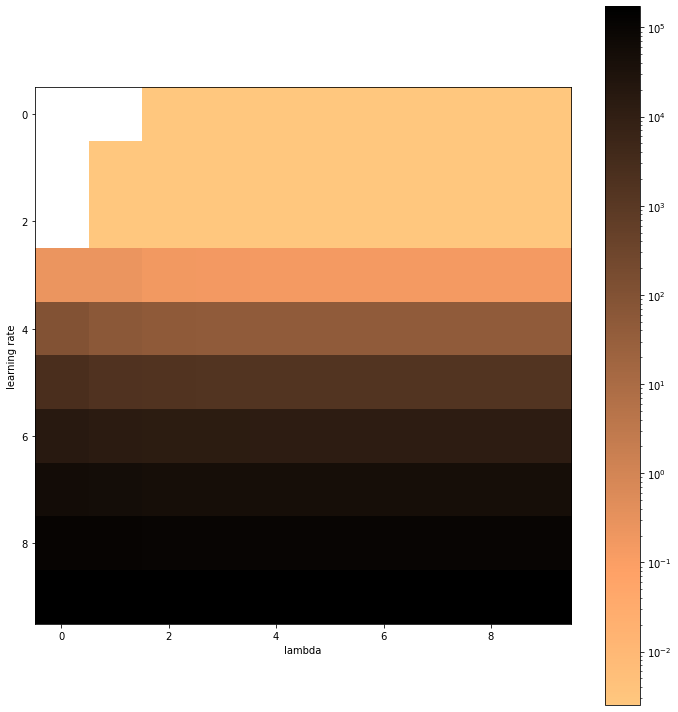

In [15]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors as cl
plt.rcParams["figure.figsize"] = [10.00, 10]
plt.rcParams["figure.autolayout"] = True
data2D = final_mse
im = plt.imshow(data2D, cmap="copper_r", norm=cl.LogNorm())
plt.xlabel('lambda')
plt.ylabel('learning rate')
plt.colorbar(im)
plt.show()


In [16]:
final_mse

array([[           nan,            nan, 2.55353708e-03, 2.55373656e-03,
        2.55580951e-03, 2.55069428e-03, 2.55144259e-03, 2.55347451e-03,
        2.55521148e-03, 2.54995306e-03],
       [           nan, 2.53378629e-03, 2.53452628e-03, 2.53353489e-03,
        2.53591110e-03, 2.53595470e-03, 2.53448758e-03, 2.53151054e-03,
        2.53554829e-03, 2.53391528e-03],
       [           nan, 2.55543296e-03, 2.54442636e-03, 2.54155119e-03,
        2.54100753e-03, 2.54015019e-03, 2.54016824e-03, 2.53933988e-03,
        2.54032534e-03, 2.54022877e-03],
       [2.44319197e-01, 2.33966678e-01, 1.73329908e-01, 1.55855931e-01,
        1.50191553e-01, 1.48205828e-01, 1.47532251e-01, 1.47252075e-01,
        1.47109572e-01, 1.47061359e-01],
       [9.54076977e+01, 5.76592140e+01, 4.80162563e+01, 4.49909000e+01,
        4.39795914e+01, 4.36174011e+01, 4.34868002e+01, 4.34384775e+01,
        4.34269094e+01, 4.34211416e+01],
       [2.36474231e+03, 1.73141455e+03, 1.55230399e+03, 1.49335788e+03,
   

The lambda doesn't seem to have an impact on performance for this simple problem. Instead, we can assess the speed of convergence to the minimum.

In [17]:
final_mse = []
for l in np.logspace(-4,-1,20):
  model = mx.mod.Module(
      symbol = lro ,
      data_names=['data'],
      label_names = ['lin_reg_label']# network structure
  )

  model.fit(train_iter, eval_iter,
              optimizer = 'dcasgd',
              optimizer_params={'learning_rate':0.5, 'lamda': l},
              num_epoch=10,
              eval_metric='mse')



  metric = mx.metric.MSE()
  final_mse.append(model.score(eval_iter, metric))

/usr/local/lib/python3.7/dist-packages/mxnet/metric.py:1198: RuntimeWarning: overflow encountered in square
  mse = ((label - pred)**2.0).mean()


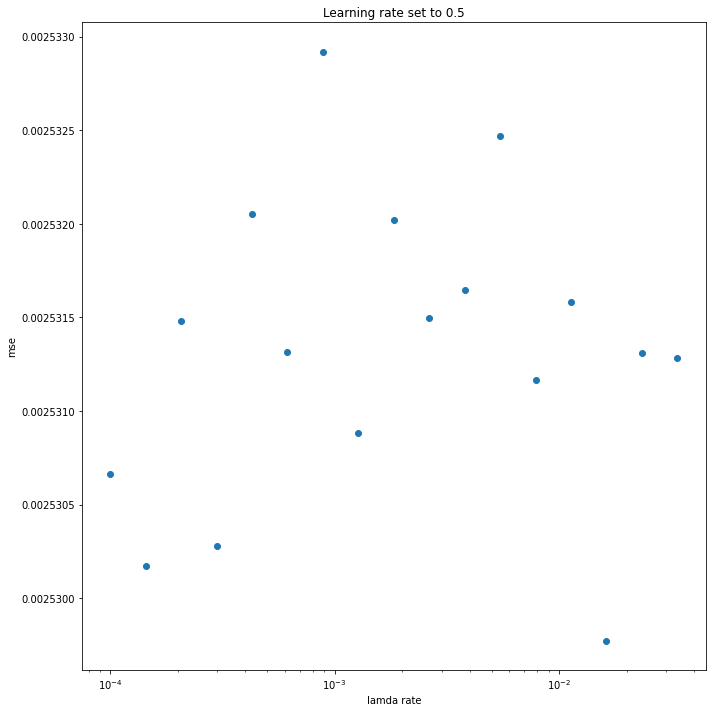

In [18]:
mses = np.array(final_mse)
mses = mses[:,0,1].astype(float)
plt.scatter(np.logspace(-4,-1,20), mses)
plt.xlabel("lamda rate")
plt.ylabel("mse")
plt.xscale('log')
plt.title('Learning rate set to 0.5')
plt.show()

We can observe that there is no trend depending on the lamda value. It doesn't lead to better performance. 

# Check number of epochs to get same precision

## SGD

In [20]:
X = mx.sym.Variable('data')
Y = mx.symbol.Variable('lin_reg_label')
fully_connected_layer  = mx.sym.FullyConnected(data=X, name='fc1', num_hidden = 10)
lro = mx.sym.LinearRegressionOutput(data=fully_connected_layer, label=Y, name="lro")

model = mx.mod.Module(
    symbol = lro ,
    data_names=['data'],
    label_names = ['lin_reg_label']# network structure
)
t = TicToc() #create instance of class

t.tic() #Start timer
model.fit(train_iter, eval_iter,
            optimizer = 'sgd',
            optimizer_params={'learning_rate':0.5, 'momentum': 0},
            num_epoch=1,
            eval_metric='mse')
t.toc()
metric = mx.metric.MSE()
print(model.score(eval_iter, metric))

Elapsed time is 0.586480 seconds.
[('mse', 8774.212646484375)]


## DC ASGD

In [21]:
t = TicToc() #create instance of class
model = mx.mod.Module(
    symbol = lro ,
    data_names=['data'],
    label_names = ['lin_reg_label']# network structure
)
t.tic() #Start timer
model.fit(train_iter, eval_iter,
            optimizer = 'dcasgd',
            optimizer_params={'learning_rate':0.5, 'lamda': 0.0001},
            num_epoch=4,
            eval_metric='mse')
t.toc() #Time elapsed since t.tic()
metric = mx.metric.MSE()
print(model.score(eval_iter, metric))

Elapsed time is 2.495058 seconds.
[('mse', 0.3104124590754509)]


# Conclusion
SGD and DCASG can reach the same accuracy, since the most efficient lamda for DCASGD is zero. Indeed, when reaching this level of precision in the problem, a lamda too high puts us at risk of getting nan value (the loss skyrockets).